In [1]:
# Imports all necessary libraries in one cell

import numpy as np
import pandas as pd
from random import choice, randint, random
from time import perf_counter
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/content/family_data.csv", index_col="family_id")

# How many members there are in each family
sizes = data.n_people.values.tolist()

# Preferred days for each family
choices = [x.tolist() for x in data.drop(["n_people"], axis=1).values]

# Cost function
family_costs = [0, 50, 50, 100, 200, 200, 300, 300, 400, 500, 500]
member_costs = [0,  0,  9,   9,   9,  18,  18,  36,  36, 235, 434]
def cost(prediction):
    res = 0
    # How many people will be attending Santa each day
    daily_occupancy = [0] *100

    for i, val in enumerate(prediction):
        daily_occupancy[val-1] += sizes[i]

        # Iterates through each choice, calculates the consolation cost for each family
        for choice in range(11):
            if choice==10 or val==choices[i][choice]:
                res += family_costs[choice] + member_costs[choice]*sizes[i]
                break
    
    # Santa must attend at least 125 but no more than 300 people each day
    for val in daily_occupancy:
        if not (125<=val<=300): return float("+inf")

    # Accounting cost; it's calculated for each two sequential days
    tmp1 = np.array([daily_occupancy[-1]] + daily_occupancy[99:0:-1])
    tmp2 = np.array(daily_occupancy[99::-1]) # The original occupancy but shifted for one day
    res += np.sum((tmp2-125.0) / 400.0 * tmp2**(0.5 + abs(tmp2 - tmp1) / 50.0))

    return res

In [15]:
class SimulatedAnnealing:
    def generate_first_population(self, cost_function, required_size):
        self.population = list()
        # Attempts to generate new genes until all genes in the first generation are valid
        while True:
            gene = np.random.randint(1, 100+1, 5000) # random schedule
            fitness = cost_function(gene)
            if fitness > 10e9: continue # if schedule is invalid, it is discarded
            self.population.append([gene, fitness]) # add vaid schedule to the population
            if len(self.population) == required_size: break
        return self.population
    

    def crossover(self, gene1, gene2):
        # Chooses two random points for two-tail crossover
        a, b = randint(0, 5000-1), randint(0, 5000-1) 
        a, b = min(a, b), max(a, b)

        # Creates new children
        child1 = np.concatenate((gene1[:a], gene2[a:b], gene1[b:]))
        child2 = np.concatenate((gene2[:a], gene1[a:b], gene2[b:]))

        return child1, child2


    def mutate(self, gene):
        # Chooses how many families will change their choices
        points = int(np.random.beta(2, self.epoch, 1)*self.mutation_degree)
        for i in range(points):
            # Chooses a random family to change
            point = randint(0, 5000-1)
            # If this family is already scheduled to its preferred day, there is a chance not to change the family
            if random()<self.rand and gene[point] in choices[point]: continue
            # Otherwise, random day is assigned to the family
            gene[point] = randint(1, 100)
        return gene


    def create_population(self, required_size, cost_function):
        # If no generation is generated yet, it must create the zero population
        if self.population is None:
            return self.generate_first_population(cost_function, required_size)
        
        new_genes = list()
        # Since the generation already has some survived best genes from the previous one,
        # the algorithm only needs to generate some fixed number of them to make up for the deficit
        while len(self.population)+len(new_genes) < required_size:
            if random()<self.rand and len(self.population)+len(new_genes)+1!=required_size:
                # randomly picks two genes to perform crossover
                cand1, cand2 = self.crossover(choice(self.population)[0], choice(self.population)[0])
                # Calculates the new genes' fitness and adds them to the population 
                fitness1, fitness2 = cost_function(cand1), cost_function(cand2)
                new_genes.append([cand1, fitness1])
                new_genes.append([cand2, fitness2])
            
            else: # picks mutation
                # randomly chooses a gene to perform mutation
                gene = choice(self.population)[0]
                candidate = self.mutate(gene)
                fitness = cost_function(candidate)
                new_genes.append([candidate, fitness])
        return self.population + new_genes
            

    def apply(self, population_size, survival_rate, epochs, cost_function, mutation_degree, verbose=False):
        # Setting the hyper-parameters
        # Mutation degree - how many families wilil change their assigned days after performing the mutation operation
        self.mutation_degree = mutation_degree
        # Not tunable parameter - if too small then the fitness results are awful; it too large then the algorithm takes unreasonably much time
        self.rand = 0.5
        self.population = None
        # How many genes will be promoted to the next generation. Note that the algorithm always keeps the best gene in each generation
        n_to_select = round(population_size*survival_rate) - 1
        t0 = perf_counter()
        self.training_history = list()

        for epoch in range(1, epochs+1):
            t = perf_counter()
            self.epoch = epoch
            
            # Creating a new population
            self.population = self.create_population(population_size, cost_function)

            # Accessing the population's performance
            self.population.sort(key=lambda l: l[1])
            self.training_history.append(self.population[0][1])

            if verbose:
                print(f"[{epoch}/{epochs}] Loss: {round(self.population[0][1], 3)}  Time spent: {round(perf_counter()-t,3)}s  Total time elapsed: {round(perf_counter()-t0, 3)}s")

            # Selecting the genes that will be promoted to the next generation, according to the beta(1, epoch) distribution, where epoch is the current epoch
            idx_of_selected = np.random.beta(1, epoch, n_to_select)
            idx_of_selected = [int(x) for x in idx_of_selected*population_size] + [0]
            self.population = [self.population[idx] for idx in idx_of_selected]
    

    def get_training_history(self):
        return self.training_history


    def save_schedule(self):
        # Saves the schedule to csv file that is ready to be submitted to kaggle competition
        schedule = pd.DataFrame({"family_id": range(5000), "assigned_day": self.population[0][0]}).set_index("family_id")
        schedule.to_csv("./schedule.csv")

In [ ]:
# grid search

results = []
pop_size = 50
n_of_epochs = 15
for survival_rate in np.linspace(0.05, 0.5, 10):
    for mutation_degree in np.linspace(20, 500, 25):
        model = SimulatedAnnealing()
        model.apply(pop_size, survival_rate, n_of_epochs, cost, mutation_degree)
        fitness = model.population[0][1]
        results.append([survival_rate, mutation_degree, fitness])

In [ ]:
best_params = sorted(results, key=lambda l:l[2])[0]
print(f"Best parameters - Survival rate: {best_params[0]}  Mutation degree: {best_params[1]}")

Best parameters - Survival rate: 0.05  Mutation degree: 340.0


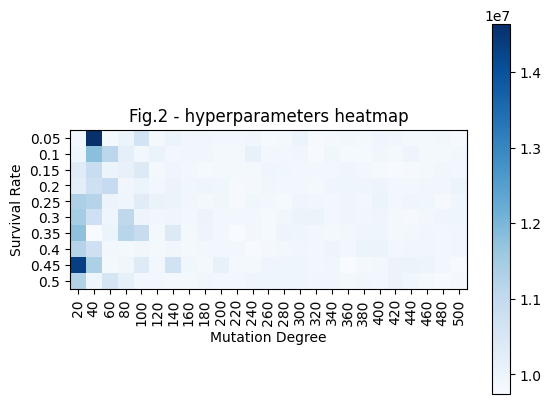

In [ ]:
costs = np.zeros((10, 25))

for i in range(10):
    for j in range(25):
        costs[i, j] = results[i+10*j][2]

r1 = [round(x, 3) for x in np.linspace(0.05, 0.5, 10)]
r2 = [int(x) for x in np.linspace(20, 500, 25)]

plt.imshow(costs, cmap="Blues", interpolation="nearest")
plt.ylabel("Survival Rate")
plt.xlabel("Mutation Degree")
plt.xticks(np.arange(len(r2)), r2)
plt.yticks(np.arange(len(r1)), r1)
plt.colorbar()
plt.title("Fig.2 - hyperparameters heatmap")
plt.show()

[1/50] Loss: 10646534.382  Time spent: 6.582s  Total time elapsed: 6.582s
[2/50] Loss: 10646534.382  Time spent: 4.523s  Total time elapsed: 11.107s
[3/50] Loss: 10485893.612  Time spent: 5.179s  Total time elapsed: 16.288s
[4/50] Loss: 10485893.612  Time spent: 4.424s  Total time elapsed: 20.713s
[5/50] Loss: 10105409.785  Time spent: 5.218s  Total time elapsed: 25.932s
[6/50] Loss: 9417351.193  Time spent: 4.416s  Total time elapsed: 30.349s
[7/50] Loss: 9365902.675  Time spent: 4.419s  Total time elapsed: 34.769s
[8/50] Loss: 9282228.185  Time spent: 5.181s  Total time elapsed: 39.951s
[9/50] Loss: 9113855.794  Time spent: 4.378s  Total time elapsed: 44.33s
[10/50] Loss: 9070873.349  Time spent: 5.18s  Total time elapsed: 49.511s
[11/50] Loss: 9070873.349  Time spent: 4.368s  Total time elapsed: 53.88s
[12/50] Loss: 9023433.419  Time spent: 4.391s  Total time elapsed: 58.272s
[13/50] Loss: 8994173.876  Time spent: 5.174s  Total time elapsed: 63.446s
[14/50] Loss: 8955238.358  Time s

Text(0.5, 1.0, 'Fig.4 - learning loss history')

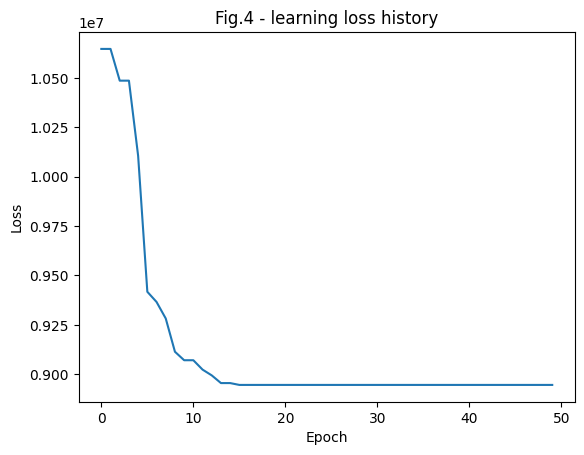

In [ ]:
model = SimulatedAnnealing()
model.apply(
    population_size = 500,
    survival_rate = 0.05,
    epochs = 50,
    cost_function = cost,
    mutation_degree = 340,
    verbose = True
)

plt.plot(model.get_training_history())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Fig.4 - learning loss history")